<a href="https://colab.research.google.com/github/bsureshkrishna/qlsc600_2023/blob/main/Neur503.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now, we will use the basics to work through a simple, but useful model of the auditory periphery.

First, importing some useful functions.. versions of some of which you have already seen before, but redefining here for ease of use with slightly different calling parameters.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, convolve
from scipy.stats import gamma
import math
import sklearn

def plot_signal_spectrum(signal, fs, plotornot = 1):
    # Compute the FFT
    fft_result = np.fft.fft(signal)

    # Compute the frequency bins
    freqs = np.fft.fftfreq(len(signal), d=1/fs)

    # Compute the magnitude (absolute value of the FFT)
    magnitude = np.abs(fft_result)

    if(plotornot==1):
        # Plotting
        sorted_indices = np.argsort(freqs)
        magnitude=magnitude[sorted_indices]
        freqs=freqs[sorted_indices]
        plt.plot(freqs, magnitude)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.title('Spectrum')

    return freqs, magnitude

def amplitude_from_spl(spl):
    amplitude = np.power(10,(spl/20))*20*1e-6 #amplitude in pascals, since reference of 0dB = 20 micropascals
    return amplitude

def generate_tone(t,spl,frequency, phasevalue=0):
    #supply amplitdue in sound pressure level (decibels), frequency in hz
    amplitude = amplitude_from_spl(spl) #amplitude in micropascals, since reference of 0dB = 20 micropascals
    signal = amplitude*np.sin(2.0*np.pi*frequency*t+phasevalue) #a simple sine-wave to use as signal
    return signal

def generate_samtone(t,spl,frequency, phasevalue=0, amfrequency=10):
    #supply amplitdue in sound pressure level (decibels), frequency in hz
    amplitude = amplitude_from_spl(spl) #amplitude in micropascals, since reference of 0dB = 20 micropascals
    signal = amplitude*(1+np.sin(2*np.pi*amfrequency*t-(np.pi)/2))*np.sin(2.0*np.pi*frequency*t+phasevalue) #a simple sine-wave to use as signal
    return signal

def timeplot(signal,fs,colorvar='blue'):
    plt.plot((1/fs)*np.arange(0,len(signal)),signal,color=colorvar)

def generate_gammatone(timeax,f=440,b=50,n=4,a=1,phi=0):
    gammapart=a*timeax**(n-1)*np.exp(-2.0*np.pi*b*timeax)
    gammapart=2*gammapart/np.trapz(gammapart)
    cospart=np.cos(2.0*np.pi*f*timeax) # a hack normalization to make convolution output "preserve" amplitude
    gammatone_impresp=cospart*gammapart #impulse response of gammatone filter
    return gammatone_impresp

We will now put all the elements we learnt before together to consider some toy, but still illustrative, examples of signal processing and signal detection by a single auditory nerve fiber. A real auditory nerve fiber is much more complex than this, but the model is still not entirely dissimilar to the auditory nerve. Front-ends like this are commonly used in artificial speech processing systems.

A single auditory nerve fiber is driven by a synapse between the inner hair cell and the auditory nerve fiber terminal, and the inner hair cell (in the inner ear) is driven by motion of the basilar membrane in a certain region. A given region of the basilar membrane responds maximally to a specific band of frequencies, and much less to those above and below it. So  a single auditory nerve fibers responds with more spikes when sounds with frequency content in a certain range are presented. Using simple tones (sine waves) as stimuli, the nerve fiber responds maximally to a band of frequencies.

Auditory nerve fibers in humans cover frequencies from about 20 Hz to 20 kHz. But only the part below about 4 kHz is relevant for speech percpetion.

A. This band-pass response is usually modeled by a gamma-tone filter. This filter is constructed via an impulse response that consists of a sinusoid multiplied with a gamma-function envelope so that the impulse response is time-limited. One property of signal-Fourier transform pairs, under conditions like these, is that wider signals in time have narrower frequency spectra (all other things being equal) and vice-versa - wider frequency spectra  correlate with narrower time-domain signals. You can understand this by considering that multiplication in the frequency domain is the same as convolution in the time domain and vice-versa - multiplication in the time-domain is the same as convolution in the frequency domain. Here, we will make do with a toy gamma-tone filter that is easier to understand. For real work, use existing implementations as digital FIR (or IIR filters) in Python (in Scipy, brian etc.) that are more faithful to biological values and also more efficient and with better phase-domain responses etc. (FIR = finite impulse response, IIR = infinite impulse response, for details, take/self-learn a basic digital signal processing course).

As, Wikipedia [says](https://en.wikipedia.org/wiki/Gammatone_filter), the gammatone impulse response is given by
$$
g(t) = at^{n-1} e^{-2\pi bt} \cos(2\pi ft + \phi), \,
$$

where f (in Hz) is the center frequency, phi  (in radians) is the phase of the carrier, a is the amplitude, n is the filter's order, b (in Hz) is the filter's bandwidth,and t (in seconds) is time. It is called a gamma-tone because the $t^{n-1} e^{-2\pi bt}$ term resembles the integrand of the gamma function.


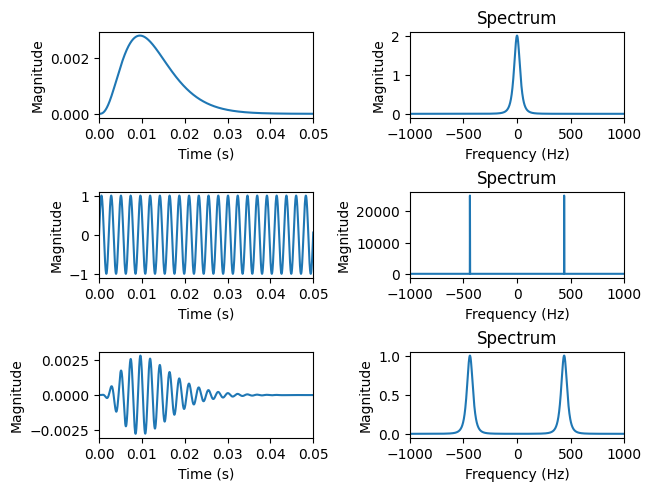

In [ ]:
#set filter parameters
a=1
n=4
b=50
f=440
phi=0
fs=50000
t=np.arange(0,1,1/fs) #1 seconds

#set signal parameters

spl=38 #in decibels
signal=generate_tone(t,spl,f)

gammapart=a*t**(n-1)*np.exp(-2.0*np.pi*b*t) #change b to change (reduce) the temporal extent; b acts like the bandwidth of the filter.
gammapart=2*gammapart/np.trapz(gammapart)
sinepart=np.sin(2.0*np.pi*f*t) # a hack normalization to make convolution output "preserve" amplitude
gammatone_impresp=sinepart*gammapart #impulse response of gammatone filter

fig, axs = plt.subplots(3, 2, layout='constrained')
plt.sca(axs[0,0]); plt.plot(t,gammapart);
plt.xlabel('Time (s)'); plt.ylabel('Magnitude'); plt.xlim(0,0.05)
plt.sca(axs[0,1]); plot_signal_spectrum(gammapart,fs)
plt.xlim(-1000,1000)
plt.sca(axs[1,0]); plt.plot(t,sinepart);
plt.xlabel('Time (s)'); plt.ylabel('Magnitude'); plt.xlim(0,0.05)
plt.sca(axs[1,1]); plot_signal_spectrum(sinepart,fs)
plt.xlim(-1000,1000)
plt.sca(axs[2,0]); plt.plot(t,gammatone_impresp)
plt.xlim(0,0.05); plt.xlabel('Time (s)'); plt.ylabel('Magnitude')
plt.sca(axs[2,1]); plot_signal_spectrum(gammatone_impresp,fs)
plt.xlim(-1000,1000)
plt.show()

**Question 1a**: Why does the spectrum in the third row look as it does ? Reason from known properties of signal-Fourier transform pairs, and the functions plotted in rows 1 and 2.

**Question 1b:** Change the temporal extent of the gamma envelope in row 1, and see the effects on row 3. Describe and interpret.

These questions illustrate the power of intuitively being able to reason about the spectral properties of different convolution operations.

Notice that the gammatone impulse response in time has a certain similarity to the well-known Gabor filter in space, which is a Gaussian (mean = 0) multiplied by a sinusoid. In the space domain, impulse responses can extend to both negative and positive values around 0, while in the time domain, non-zero impulse response values for times less than 0 would violate something.

**Question 1c**: what would it violate ?

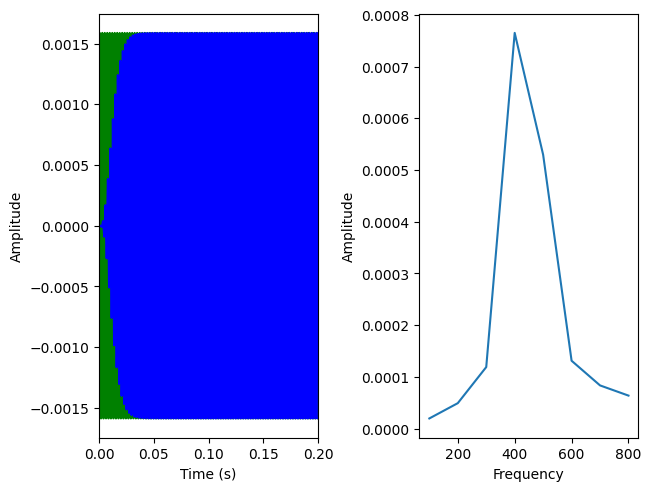

In [ ]:
gammatone_output = convolve(signal,gammatone_impresp)

frequencies=np.arange(100,900,100)
output_across_frequencies=np.zeros(len(frequencies))
for i in range(len(frequencies)):
    temp=generate_tone(t,spl,frequencies[i])
    output_across_frequencies[i]=np.max(convolve(temp,gammatone_impresp))

fig, axs = plt.subplots(1, 2, layout='constrained')
plt.sca(axs[0]); timeplot(signal,fs,'green'); timeplot(gammatone_output,fs,'blue')
plt.xlim(0,0.2); plt.xlabel('Time (s)'); plt.ylabel('Amplitude')

plt.sca(axs[1]); plt.plot(frequencies,output_across_frequencies)
plt.xlabel('Frequency'); plt.ylabel('Amplitude')

plt.show()

The green plot above in the first column is the original signal, and the blue part is after gammatone-filtering.

In-class question (not for assignment): Why is the shape of the filtered output initially different ? Explain by appealing to your understanding of convolution. You can draw a figure if you want.

Next, we pass the output of the gammatone-filter through a half-wave rectifier followed by a low-pass filter. This captures the fact that the inner hair-cell mainly tracks deflections in 1 direction, and the processes between the inner-hair cell potential and neuronal firing (includng the synaptic time-constant) smooth the driving rate-function and very high frequencies will not go through.

To do the low-pass filtering, we can convolve the output of the nonlinearity with a low-pass filter. Here, we can again use a gamma function (as above) for simplicity. Adjusting b adjusts the width of the gamma part of the gammatone and affects the frequency bandwidth.

In-class: Why ?

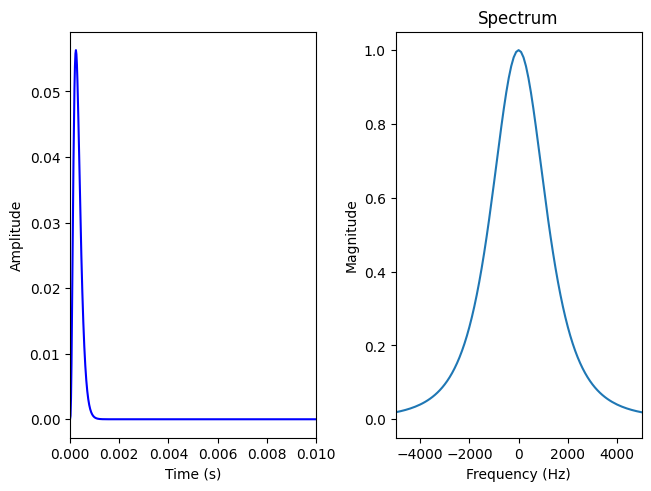

In [ ]:
def lowpass_create(b=2000, duration=0.01):
    #rough bandwidth, 1/b is rough temporal extent of impulse response
    #set filter parameters
    a=1
    n=4
    #10 milliseconds will do, since impulse respnse will be 0 after that for all plausible values..
    #10 ms duration is roughly a cutoff of 100 hz, btu real cutoffs wold be well above 1000 hz, so the
    #impulse response willl be much briefer in druation (why).
    #reducing the duration will sbstnatially speed up convolution operations with this impulse response. why ?
    lowpass_time=np.arange(0,duration,1/fs)
    lowpass_impresp=a*np.power(lowpass_time,(n-1))*np.exp(-2.0*np.pi*b*lowpass_time)
    lowpass_impresp=lowpass_impresp/np.trapz(lowpass_impresp)
    return lowpass_impresp

b=2000 #can vary this and see how bandwidth changes
lowpass_impresp=lowpass_create(b)
fig, axs = plt.subplots(1, 2, layout='constrained')
plt.sca(axs[0]); timeplot(lowpass_impresp,fs); plt.xlim([0,0.01]); plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.sca(axs[1]); a,b = plot_signal_spectrum(lowpass_impresp,fs); plt.xlim(-5000,5000)
plt.show()

So now we are finally ready to make the full model. We have gone through all the required elements here (except for the spike-train driving function,  which we created already in class 3).

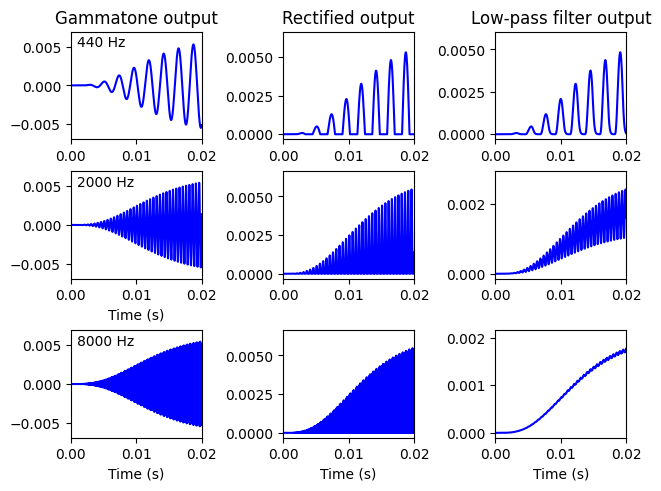

In [ ]:
def simulate_inhomogeneous_poisson(times, rate_function, numtrials=1):
    # Example usage:
    # times = np.linspace(0, 10, 10000)  # Define the time points
    # rate_function = np.sin(2.0*np.pi*0.5*times) * 25 + 25  # Define the rate function, ensuring it is non-negative
    # events = simulate_inhomogeneous_poisson(times, rate_function)
    # Now 'events' contains the event times of the inhomogeneous Poisson process
    inhomogeneous_poisson_events_times=[]
    spike_counts=np.zeros(numtrials)
    for trial in np.arange(0,numtrials):
      # Integrate the rate function to get the compensator (cumulative rate function)
      compensator = np.cumsum(rate_function) * (times[1] - times[0])
      # Generate a standard Poisson process with rate 1
      n_events = np.random.poisson(compensator[-1])
      standard_poisson_events = np.sort(np.random.uniform(0, compensator[-1], n_events))

      # Apply the inverse of the cumulative rate function to the event times
      # We find where each standard Poisson event would fall in the compensator
      inhomogeneous_poisson_events = np.searchsorted(compensator, standard_poisson_events, side='left')
      inhomogeneous_poisson_events_times.append([times[inhomogeneous_poisson_events]])
      spike_counts[trial]=len(inhomogeneous_poisson_events)

    return spike_counts, inhomogeneous_poisson_events_times

import copy

def fullmodel(signal, fs, gammatone_centerfreq=440, gammatone_b=50, lowpass_b=2000, spikesout=0, numtrials=20, Rmult=3000):
    #this takes in any signal and returns either an auditory nerve rate-function or spike-train
    gammatone_timeax=np.arange(0,0.5,1/fs) #500 ms duration should be more than enough.
    gammatone_impresp=generate_gammatone(gammatone_timeax,f=gammatone_centerfreq, b=gammatone_b)
    gammatone_output=np.convolve(signal,gammatone_impresp)
    rectified_output=copy.deepcopy(gammatone_output); rectified_output[rectified_output<=0]=0
    lowpass_impresp=lowpass_create()
    lowpass_output=np.convolve(rectified_output,lowpass_impresp)
    if spikesout==0:
        return lowpass_output, rectified_output, gammatone_output
    else:
        return simulate_inhomogeneous_poisson((1/fs)*np.arange(0,len(lowpass_output)), Rmult*lowpass_output, numtrials)

spl=50 #in decibels
freqs=[440,2000,8000] #in hz
t=np.arange(0,1,1/fs) #1 seconds

fig, axs = plt.subplots(len(freqs), 3, layout='constrained')

for idx,f in enumerate(freqs):
  signal=generate_tone(t,spl,f)
  lowpass_output, rectified_output, gammatone_output = fullmodel(signal,fs, gammatone_centerfreq=f) #not getting spike-train output
  plt.sca(axs[idx,0]); timeplot(gammatone_output,fs); plt.xlim([0,0.02])
  plt.sca(axs[idx,1]); timeplot(rectified_output,fs); plt.xlim([0,0.02])
  plt.sca(axs[idx,2]); timeplot(lowpass_output,fs); plt.xlim([0,0.02])
  if idx==0:
    plt.sca(axs[idx,0]);plt.title('Gammatone output');plt.annotate('440 Hz',(0.001,0.005))
    plt.sca(axs[idx,1]);plt.title('Rectified output')
    plt.sca(axs[idx,2]);plt.title('Low-pass filter output')
  if idx==1:
    plt.sca(axs[idx,0]);plt.xlabel('Time (s)');plt.annotate('2000 Hz',(0.001,0.005))
  if idx==2:
    plt.sca(axs[idx,0]);plt.xlabel('Time (s)');plt.annotate('8000 Hz',(0.001,0.005))
    plt.sca(axs[idx,1]);plt.xlabel('Time (s)');
    plt.sca(axs[idx,2]);plt.xlabel('Time (s)');


plt.show()

**Question 2**: Explain the plot above. Specifically focus on explaining the features you see in the waveforms in the third column. Expand the time-window visible in the x-axis as needed using plt.xlim

Note that in this graph, the gammatone filter's center frequency changes in each row to be equal to the stimulus frequency.

In-class: try different freqencies and bandwidths - see what happens.


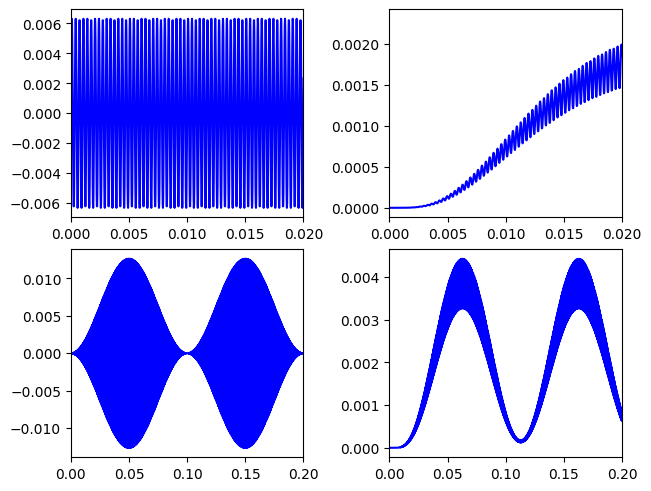

In [ ]:
spl=50 #in decibels
t=np.arange(0,1,1/fs) #1 seconds

fig, axs = plt.subplots(2, 2, layout='constrained')

f=3000;
signal=generate_tone(t,spl,f)
lowpass_output, rectified_output, gammatone_output = fullmodel(signal,fs, gammatone_centerfreq=f) #not getting spike-train output
plt.sca(axs[0,0]); timeplot(signal,fs); plt.xlim([0,0.02])
plt.sca(axs[0,1]); timeplot(lowpass_output,fs); plt.xlim([0,0.02])

signal=generate_samtone(t,spl,f)
lowpass_output, rectified_output, gammatone_output = fullmodel(signal,fs, gammatone_centerfreq=f) #not getting spike-train output
plt.sca(axs[1,0]); timeplot(signal,fs); plt.xlim([0,0.2])
plt.sca(axs[1,1]); timeplot(lowpass_output,fs); plt.xlim([0,0.2])

plt.show()

**Question 3**: Plot the spectra of these two signals. Go through the full model. Try to explain why the output plotted in column 2 behaves as it does. Why do carrier frequencies not really go through but modulation frequencies go through to the output ?

Now we can start doing some experiments based on spikes. Let us plot a classical frequency tuning curve based on total spike-count.

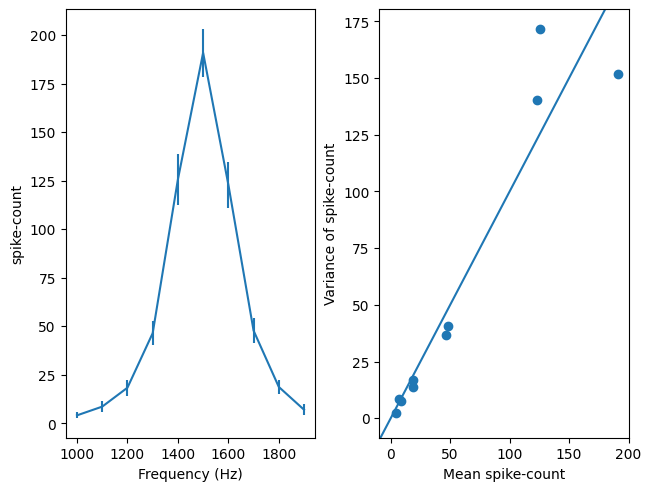

In [ ]:
spl=80 #in decibels
freqs=np.arange(4200,5800,100)
freqs=np.arange(1000,2000,100)
t=np.arange(0,1,1/fs) #1 seconds

spikecounts=np.zeros(len(freqs))
spikecounts_sd=np.zeros(len(freqs)) #dont do spikeconts = spikeconts_sd.. python copy is weird !
spikecounts_var=np.zeros(len(freqs))

for i in range(len(freqs)):
  signal=generate_tone(t,spl,freqs[i])
  lowpass_output, nonlinearity_output, gammatone_output = fullmodel(signal,fs)
  #sc, spiketrain = fullmodel(signal,fs, spikesout=1, gammatone_centerfreq=5000, gammatone_b=600)
  sc, spiketrain = fullmodel(signal,fs, spikesout=1, gammatone_centerfreq=1500, gammatone_b=200)

  spikecounts[i]=np.mean(sc)
  spikecounts_sd[i]=np.std(sc) #/np.sqrt(len(sc))
  spikecounts_var[i]=np.var(sc)


fig, axs = plt.subplots(1, 2, layout='constrained')
plt.sca(axs[0]); plt.errorbar(freqs,spikecounts,spikecounts_sd); plt.xlabel('Frequency (Hz)'); plt.ylabel('spike-count')
plt.sca(axs[1]); axs[1].scatter(spikecounts,spikecounts_var); axs[1].axline((0,0),slope=1); plt.xlabel('Mean spike-count'); plt.ylabel('Variance of spike-count')
plt.show()

In-class: try different frequencies - see what happens. What parameter sets the bandwidth of the tuning-curve ?

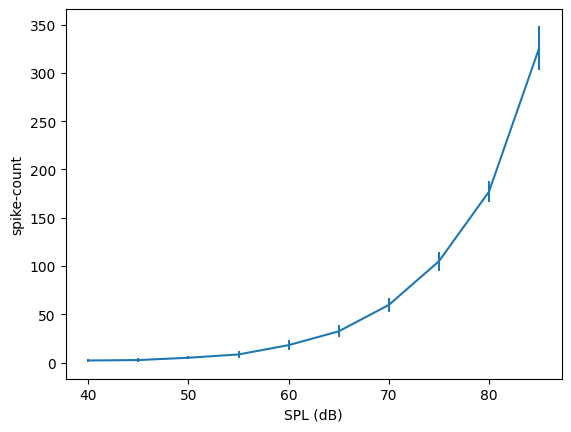

In [ ]:
spls=np.arange(40,90,5) #in decibels
f=5000
t=np.arange(0,1,1/fs) #1 seconds

spikecounts=np.zeros(len(spls))
spikecounts_sd=np.zeros(len(spls)) #dont do spikeconts = spikeconts_sd.. python copy is weird !
spikecounts_var=np.zeros(len(spls))

for i in range(len(spls)):
  signal=generate_tone(t,spls[i],f)
  lowpass_output, nonlinearity_output, gammatone_output = fullmodel(signal,fs)
  #sc, spiketrain = fullmodel(signal,fs, spikesout=1, gammatone_centerfreq=5000, gammatone_b=600)
  sc, spiketrain = fullmodel(signal,fs, spikesout=1, gammatone_centerfreq=f, gammatone_b=600)

  spikecounts[i]=np.mean(sc)
  spikecounts_sd[i]=np.std(sc) #/np.sqrt(len(sc))
  spikecounts_var[i]=np.var(sc)

#fig, axs = plt.subplots(1, 2, layout='constrained')
#plt.sca(axs[0]);
plt.errorbar(spls,spikecounts,spikecounts_sd); plt.xlabel('SPL (dB)'); plt.ylabel('spike-count')
#plt.sca(axs[1]);
plt.show()

Finally, (yes, finally), we are going to look at how well an ideal observer can do just by recording the spike count from 1 toy auditory nerve fiber in response to two tones and being asked to say which tone is louder. We will do this experiment at different base sound pressre levels, and try to estimate what increment is needed at each base level to be correct 84 % of the time. We have all the machinery we need for this.

Note that we are using a spike-count based code. OTher codes are possible, for example those based on timing. And of course those based on populations of such fibers to create multivariate codes. Those would do in a longer course. In these cases, the signal detection theory would be developed similarly, but with appropriate modifications.

**Question 4**: Our target is to evaluate if our toy model provides an explanation for the classical law of psychophysics known as Weber's law. Weber's law (yo can look it up) says that the increment in sond pressure level that one needs over a base sound pressr level in order to detect the louder tone correctly x % of the time (let us say x=84 for now) increases proportionately to the base spl. That is, $ ΔI/I = k $. If we base or decisions on the spike-counts and our model, do we get a prediction consistent with this law ?

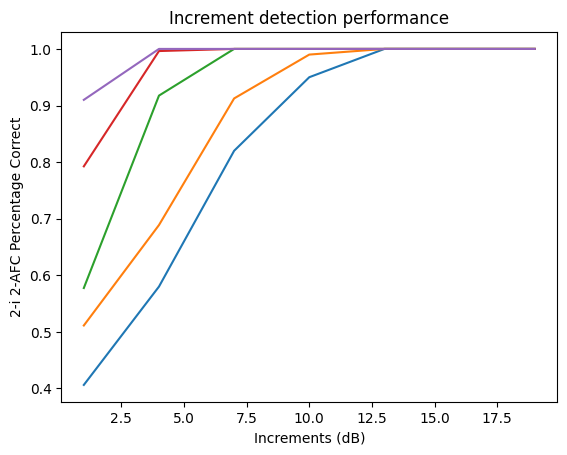

In [ ]:
from sklearn.metrics import roc_curve, auc

spls=np.arange(40,90,10) #in decibels
increments=np.arange(1,20,3) #spl increments; COARSE RIGHT NOW. MAKE finer for question 4
f=5000
t=np.arange(0,1,1/fs) #1 seconds

for i in range(len(spls)):
  signal=generate_tone(t,spls[i],f)
  lowpass_output, nonlinearity_output, gammatone_output = fullmodel(signal,fs)
  #sc, spiketrain = fullmodel(signal,fs, spikesout=1, gammatone_centerfreq=5000, gammatone_b=600)
  sc, spiketrain = fullmodel(signal,fs, spikesout=1, gammatone_centerfreq=f, gammatone_b=600)

  percor=np.zeros(len(increments))

  for i1 in range(len(increments)):
      signal=generate_tone(t,spls[i]+increments[i1],f)
      lowpass_output, nonlinearity_output, gammatone_output = fullmodel(signal,fs)
      #sc, spiketrain = fullmodel(signal,fs, spikesout=1, gammatone_centerfreq=5000, gammatone_b=600)
      sc1, spiketrain = fullmodel(signal,fs, spikesout=1, gammatone_centerfreq=f, gammatone_b=600)

      spikevalues=np.concatenate([sc,sc1])
      spikelabels=np.concatenate([np.zeros(len(sc)),np.ones(len(sc1))])
      # Compute ROC curve and area
      fpr, tpr, thresholds = roc_curve(spikelabels, spikevalues)
      percor[i1] = auc(fpr, tpr)

  plt.plot(increments,percor);
  plt.xlabel('Increments (dB)')
  plt.ylabel('2-i 2-AFC Percentage Correct')
  plt.title('Increment detection performance')
  #plt.legend(loc="lower right")


plt.show()


**Question 4 (continued)** The plot above gives you the increment-detection performance one would get based on our toy model for different base spls. You can use a finer increment to manually estimate the increment needed to get 84 % correct in a two-interval, two-alernative forced-choice task. If you program fluently, you can use interpolation etc. In either case, make a plot of the threshold increment (that prodces 84 % correct) versus the base spl. Describe how it compares to Weber's law qualitatively.

If it does not fit Weber's law, consider what is needed in terms of the spike-count variance vs. mean relationship to fit Weber's law. Should the variance increase or decrease from what the model prodces for a given spike-count ? Why ?

Could, just possibly, a nerve fiber whose spike-count decreased with increasing intensity (the opposite of what our toy model currently produces) fit Weber's law ? And why ? Such responses do not exist in the auditory  nerve, but they do exist at higher levels of the auditory pathway.  

That is it. I hope you all found it a meaningful and positive learning experience. Please do take some moments to fill in the feedback form or website etc.